# Problem 1: Visualize a static map (8 points)

Create a static map using the skills you leared in lesson 5. The map should contain multiple layers of data (at least two different data sets), and you should pay attention to the classification and visualization (colors, edges etc.) when creating the map. Write your code into a notebook file (.ipynb) or a python script file (.py) and store the output map(s) in .png format into the docs folder.

Topic of the map:

    You can either use the data sets we have already used during this course (eg. the Travel Time Matrix, or population grid), or you can select some other data set of your interest (for example, statistics in postal code areas).
    Feel free to adapt examples provided in this course! You can do further calculations based on the datasets or use the analysis outputs that we have done earlier in the course (for example, the dominance areas or travel times for shopping centers).

Criteria:

    The map should have multiple layers on it (for example, the travel time matrix and the road network). Basemap is optional (use a basemap only if it adds useful information / visual touch!)
    The map should portray some kind of classification and/or an analysis output (not just the raw data).
    Consider good cartographic practices (map extent, zoom level, color choices, legend, credit data sources etc.) when plotting the map.

Output:

    Remember to commit the code and input data (or at least a link to input data)
    Save your map(s) as png image in the docs folder


In this exercise, I will use municipality polygons (2018), municipality-wise employment rates (2017), and population numbers (2018) provided by Statistics Finland. I will also use a text file containing the addresses for Finland's region center cities which I put together myself. The addresses for each city is the city's townhouse's address. I looked up the addresses from Google Maps.

In [44]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import json
import numpy as np
from pyproj import CRS

In [21]:
# Download the municipality polygons from year 2018

url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k_2018&outputformat=JSON"
geokunnat = gpd.read_file(url)

# Read the municipality-wise employment rates (2017) and population numbers (2018)

kunnat = pd.read_excel(r"data/Kunnat_tyollisyys_vakiluku.xlsx")




In [22]:
kunnat.head()

,Unnamed: 0,"Väkiluku, 2018","Työllisyysaste, %, 2017"
0,Akaa,16611,71.9
1,Alajärvi,9700,67.7
2,Alavieska,2573,71.5
3,Alavus,11544,69.5
4,Asikkala,8149,69.1


In [23]:
geokunnat.head()

,id,kunta,vuosi,nimi,namn,name,geometry
0,kunta1000k_2018.1,005,2018,Alajärvi,Alajärvi,Alajärvi,"MULTIPOLYGON (((347302.684 6959056.438, 348733..."
1,kunta1000k_2018.2,009,2018,Alavieska,Alavieska,Alavieska,"MULTIPOLYGON (((370424.741 7104339.037, 371535..."
2,kunta1000k_2018.3,010,2018,Alavus,Alavus,Alavus,"MULTIPOLYGON (((319892.311 6920033.249, 319415..."
3,kunta1000k_2018.4,016,2018,Asikkala,Asikkala,Asikkala,"MULTIPOLYGON (((434407.880 6774122.311, 438438..."
4,kunta1000k_2018.5,018,2018,Askola,Askola,Askola,"MULTIPOLYGON (((423421.791 6704555.878, 425989..."


In [24]:
# Drop the unnecessary columns from geokunnat and rename kunnat column "Unnamed: 0" to "nimi"; rename also other kunnat columns to be more simple

geokunnat = geokunnat[["nimi", "geometry"]]

kunnat = kunnat.rename(columns={"Unnamed: 0": "nimi", "Väkiluku, 2018": "pop18", "Työllisyysaste, %, 2017": "employment17"})

In [25]:
# Join these two layers

merged = geokunnat.merge(kunnat, on="nimi", how="left")

merged

# Hmmm, it seems that there's a problem that I didn't realize before since all values in the columns from kunnat become NaN.

,nimi,geometry,pop18,employment17
0,Alajärvi,"MULTIPOLYGON (((347302.684 6959056.438, 348733...",NaN,NaN
1,Alavieska,"MULTIPOLYGON (((370424.741 7104339.037, 371535...",NaN,NaN
2,Alavus,"MULTIPOLYGON (((319892.311 6920033.249, 319415...",NaN,NaN
3,Asikkala,"MULTIPOLYGON (((434407.880 6774122.311, 438438...",NaN,NaN
4,Askola,"MULTIPOLYGON (((423421.791 6704555.878, 425989...",NaN,NaN
...,...,...,...,...
306,Ylitornio,"MULTIPOLYGON (((358732.539 7341893.208, 359611...",NaN,NaN
307,Ylivieska,"MULTIPOLYGON (((382933.310 7092789.500, 384323...",NaN,NaN
308,Ylöjärvi,"MULTIPOLYGON (((318400.367 6825031.514, 319504...",NaN,NaN
309,Ähtäri,"MULTIPOLYGON (((345455.367 6918226.112, 346809...",NaN,NaN


In [26]:
geokunnat_nimet = geokunnat["nimi"]

geokunnat_nimet.to_csv(r"data/nimet.csv")

In [27]:
kunnat["nimi"] == geokunnat["nimi"]

# And there's the problem: the municipalities in these two datasets don't match. 
# It seems that the municipalities in geokunnat aren't in an alphabetical order.

0      False
1      False
2      False
3      False
4      False
       ...  
306    False
307    False
308    False
309    False
310    False
Name: nimi, Length: 311, dtype: bool

In [28]:
# So, let's sort geokunnat according to nimi and see, what happens.

geokunnat = geokunnat.sort_values(by=["nimi"], ignore_index=True)

# I'll sort kunnat also, just to be sure.
kunnat = kunnat.sort_values(by=["nimi"], ignore_index=True)

geokunnat

,nimi,geometry
0,Akaa,"MULTIPOLYGON (((324952.559 6773513.092, 327649..."
1,Alajärvi,"MULTIPOLYGON (((347302.684 6959056.438, 348733..."
2,Alavieska,"MULTIPOLYGON (((370424.741 7104339.037, 371535..."
3,Alavus,"MULTIPOLYGON (((319892.311 6920033.249, 319415..."
4,Asikkala,"MULTIPOLYGON (((434407.880 6774122.311, 438438..."
...,...,...
306,Ylivieska,"MULTIPOLYGON (((382933.310 7092789.500, 384323..."
307,Ylöjärvi,"MULTIPOLYGON (((318400.367 6825031.514, 319504..."
308,Ypäjä,"MULTIPOLYGON (((296901.865 6736363.869, 297095..."
309,Ähtäri,"MULTIPOLYGON (((345455.367 6918226.112, 346809..."


In [29]:
kunnat["nimi"] == geokunnat["nimi"]

# Okey, so the names aren't the same now either. I really don't understand, why. There has to be something about the municipality names that I don't see.

0      False
1      False
2      False
3      False
4      False
       ...  
306    False
307    False
308    False
309    False
310    False
Name: nimi, Length: 311, dtype: bool

In [30]:
# I'll try to do the merge with "join" function, using index as the key.

geodata = geokunnat.join(kunnat, lsuffix='_caller', rsuffix='_other')

geodata

# Now it seems to be working fine and dandy!

,nimi_caller,geometry,nimi_other,pop18,employment17
0,Akaa,"MULTIPOLYGON (((324952.559 6773513.092, 327649...",Akaa,16611,71.9
1,Alajärvi,"MULTIPOLYGON (((347302.684 6959056.438, 348733...",Alajärvi,9700,67.7
2,Alavieska,"MULTIPOLYGON (((370424.741 7104339.037, 371535...",Alavieska,2573,71.5
3,Alavus,"MULTIPOLYGON (((319892.311 6920033.249, 319415...",Alavus,11544,69.5
4,Asikkala,"MULTIPOLYGON (((434407.880 6774122.311, 438438...",Asikkala,8149,69.1
...,...,...,...,...,...
306,Ylivieska,"MULTIPOLYGON (((382933.310 7092789.500, 384323...",Ylivieska,15212,70.9
307,Ylöjärvi,"MULTIPOLYGON (((318400.367 6825031.514, 319504...",Ylöjärvi,32983,76.6
308,Ypäjä,"MULTIPOLYGON (((296901.865 6736363.869, 297095...",Ypäjä,2357,71.2
309,Ähtäri,"MULTIPOLYGON (((345455.367 6918226.112, 346809...",Ähtäri,5703,68.9


In [31]:
# Check the crs of geodata

print(geodata.crs)

epsg:3067


In [32]:
# Reproject

geodata = geodata.to_crs("EPSG:3879")

In [33]:
# Let's once again check the data now that we have the municipality names from both datasets.

pd.set_option('display.max_rows', None)

geodata

,nimi_caller,geometry,nimi_other,pop18,employment17
0,Akaa,"MULTIPOLYGON (((25432855.364 6772522.137, 2543...",Akaa,16611,71.9
1,Alajärvi,"MULTIPOLYGON (((25449483.076 6958686.809, 2545...",Alajärvi,9700,67.7
2,Alavieska,"MULTIPOLYGON (((25468062.983 7104646.044, 2546...",Alavieska,2573,71.5
3,Alavus,"MULTIPOLYGON (((25423291.995 6918828.726, 2542...",Alavus,11544,69.5
4,Asikkala,"MULTIPOLYGON (((25542265.535 6776476.194, 2554...",Asikkala,8149,69.1
5,Askola,"MULTIPOLYGON (((25533400.510 6706582.537, 2553...",Askola,4958,77.9
6,Aura,"MULTIPOLYGON (((25366506.122 6719591.569, 2536...",Aura,3984,78.0
7,Brändö,"MULTIPOLYGON (((25280223.667 6732167.929, 2528...",Brändö,449,80.8
8,Eckerö,"MULTIPOLYGON (((25202411.338 6707350.762, 2520...",Eckerö,961,82.0
9,Enonkoski,"MULTIPOLYGON (((25705112.555 6882690.638, 2570...",Enonkoski,1405,65.6


In [34]:
# Set the data frame display back to 5 first, 5 last rows.

pd.set_option('display.max_rows', 10)

# Delete the unnecessary column "nimi_caller" and rename "nimi_oher"

geodata = geodata[["geometry", "nimi_other", "pop18", "employment17"]]

geodata = geodata.rename(columns={"nimi_other": "name"})

Okey, everything looks as it should be. Now, let's visualize the data!

I think that I could classify the population and employment columns and try to somehow visualize them together.

I could try to see if those two are related somehow.

Actually, I'll first see if there's correlation between them.

In [35]:
# Pearson correlation
from scipy import stats

stats.pearsonr(geodata["pop18"], geodata["employment17"])

(-0.006017851842099295, 0.9158207073900534)

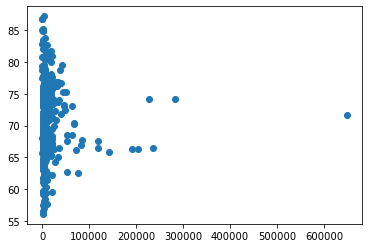

In [36]:
plt.scatter(geodata["pop18"], geodata["employment17"])

Correlation seems to be nonexistent (-0.006) wich is most likely caused by the distribution of population: most of the municipalities seem to have some thousands of residents, with some "outliers" having around 100000-300000 residents and one (Helsinki) over 600000.

Let's decide the classifying method to use when plotting the data. Employment data seems to be somewhat normally distributed, so e.g. equal intervals could work for it; however, population data is heavily skewed to the left (towards smaller values).

Let's take a closer look to the population data to decide the classifying method for it since the values are so clumped in the scatter plot that it is impossible to make any inferences. I'll use the same classification method for both datasets, defining it according to population.

In [37]:
from numpy import mean, median

print("Minimum: ", min(geodata["pop18"]))
print("Maximum: ", max(geodata["pop18"]))
print("Mean: ", round(mean(geodata["pop18"]), 0))
print("Median: ", round(median(geodata["pop18"]), 0))

Minimum:  91
Maximum:  648042
Mean:  17743.0
Median:  6081.0


I'll use natural breaks as the classification scheme with nine classes for both datasets.

I'll also bring one more data set to this exercise, namely region centers (maakuntakeskukset) to visualize how the inhabitants and employment relate to them. I put the file together myself, using the corresponding townhouse address as the address for each city.

In [39]:
from geopandas.tools import geocode
from shapely.geometry import Point, Polygon, MultiPolygon

# Read the data

mkkeskus = pd.read_csv('data/mkkeskukset.txt', sep=';')

# Geocode the addresses using Nominatim

geokeskus = geocode(mkkeskus["osoite"], provider="nominatim", user_agent='autogis_SP', timeout=3)

geokeskus.head()

,geometry,address
0,POINT (24.95287 60.16825),"Helsingin kaupungintalo, 11-13, Pohjoisesplana..."
1,POINT (22.26864 60.44879),"Turun kaupungintalo, 2, Aurakatu, Aninkaistenm..."
2,POINT (21.79485 61.48898),"Porin Kaupungintalo, 12, Hallituskatu, Kirjuri..."
3,POINT (24.46689 60.99599),"Silmälääkäri Miikael Heiskanen, 16, Palokunnan..."
4,POINT (23.76044 61.49599),"Aleksis Kiven katu, Tammerkoski, Ratina, Tampe..."


In [40]:
# Let's add the columns that went lost in translation: 

geokeskus["maakunta"] = mkkeskus["maakunta"]
geokeskus["kaupunki"] = mkkeskus["kaupunki"]

geokeskus.head()

,geometry,address,maakunta,kaupunki
0,POINT (24.95287 60.16825),"Helsingin kaupungintalo, 11-13, Pohjoisesplana...",Uusimaa,Helsinki
1,POINT (22.26864 60.44879),"Turun kaupungintalo, 2, Aurakatu, Aninkaistenm...",Varsinais-Suomi,Turku
2,POINT (21.79485 61.48898),"Porin Kaupungintalo, 12, Hallituskatu, Kirjuri...",Satakunta,Pori
3,POINT (24.46689 60.99599),"Silmälääkäri Miikael Heiskanen, 16, Palokunnan...","Häme, Kantahäme",Hämeenlinna
4,POINT (23.76044 61.49599),"Aleksis Kiven katu, Tammerkoski, Ratina, Tampe...",Pirkanmaa,Tampere


In [41]:
# Convert the crs and check the result

geokeskus = geokeskus.to_crs(geodata.crs)

print(geokeskus.crs)

EPSG:3879


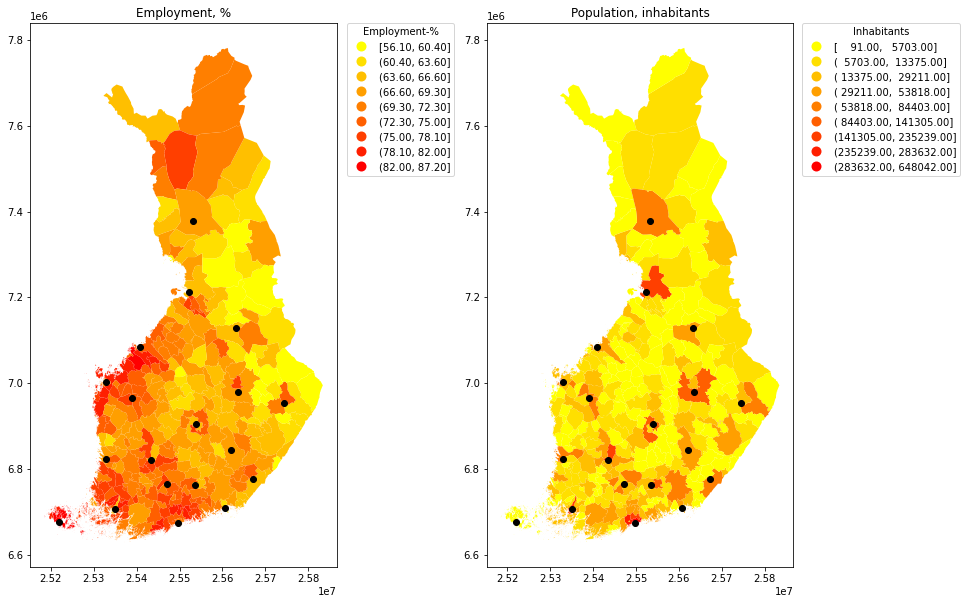

In [45]:
# Define output filename for the figure in here and use it when saving the file
# output_fig = "static_map.png"

# Plot the data into two subplots with 1 row and 2 columns.

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

geodata.plot(ax=axes[0],
             column="employment17",
             scheme="NaturalBreaks",
             k=9,
             cmap="autumn_r",
             legend=True
             );
axes[0].set_title("Employment, %")

geodata.plot(ax=axes[1],
             column="pop18",
             scheme="NaturalBreaks",
             k=9,
             cmap="autumn_r",
             legend=True
             );
axes[1].set_title("Population, inhabitants")

geokeskus.plot(ax=axes[0], 
               color="black",
              );

geokeskus.plot(ax=axes[1], 
               color="black",
               );

# Re-position the legends and set a title

axes[0].get_legend().set_bbox_to_anchor((1.4, 1.01))
axes[0].get_legend().set_title("Employment-%")

axes[1].get_legend().set_bbox_to_anchor((1.56, 1.01))
axes[1].get_legend().set_title("Inhabitants")

# Save the image to file

# plt.savefig(output_fig)

As one would expect, employment rates and population numbers are higher closer to the region centers. Lapland seems to be an exception regarding employment, this could be caused for example because of tourism-related jobs that can be located further away from Rovaniemi and other towns in the area. Interestingly, the number of inhabitants and employment rate don't seem to be very highly related. There are some indications of a correlation between those two, but the relationship is much weaker than I expected.

Since the maps above are quite basic and didn't really involve much processing, I decided to do better ones: 

I will define dominance areas for each region center city by calculating centroid for each municipality polygon and then finding the nearest city for each of them. This approach has its limitations since it doesn't account for travel times, roads, etc., but it could perhaps be developed further by adding other datas sets.

In [46]:
# Calculate centroid for each municipality and save it to a new column named "centroid"

geodata["centroid"] = None

for index, row in geodata.iterrows():
    poly = row.geometry
    centr = poly.centroid
    geodata.loc[index, "centroid"] = centr

In [47]:
geodata.head()

,geometry,name,pop18,employment17,centroid
0,"MULTIPOLYGON (((25432855.364 6772522.137, 2543...",Akaa,16611,71.9,POINT (25432548.47977924 6783254.51208106)
1,"MULTIPOLYGON (((25449483.076 6958686.809, 2545...",Alajärvi,9700,67.7,POINT (25444611.01079298 6985508.925852679)
2,"MULTIPOLYGON (((25468062.983 7104646.044, 2546...",Alavieska,2573,71.5,POINT (25467511.61630115 7120187.997117932)
3,"MULTIPOLYGON (((25423291.995 6918828.726, 2542...",Alavus,11544,69.5,POINT (25427913.73972826 6942440.066593251)
4,"MULTIPOLYGON (((25542265.535 6776476.194, 2554...",Asikkala,8149,69.1,POINT (25531525.14987801 6789205.303534576)


In [48]:
# Create a unary union of the cities in geokeskus

geounion = geokeskus["geometry"].unary_union

# Create a new column named "nearest_city" and calculate the nearest city for each municipality

from shapely.ops import nearest_points

geodata["nearest_city"] = None

for index, row in geodata.iterrows():
    point = row.centroid
    multipoint = geounion
    queried_geom, nearest_geom = nearest_points(point, multipoint)
    geodata.loc[index, "nearest_city"] = nearest_geom

In [49]:
geodata.head()

,geometry,name,pop18,employment17,centroid,nearest_city
0,"MULTIPOLYGON (((25432855.364 6772522.137, 2543...",Akaa,16611,71.9,POINT (25432548.47977924 6783254.51208106),POINT (25433981.73634464 6821390.614003492)
1,"MULTIPOLYGON (((25449483.076 6958686.809, 2545...",Alajärvi,9700,67.7,POINT (25444611.01079298 6985508.925852679),POINT (25389867.58878904 6966457.940480988)
2,"MULTIPOLYGON (((25468062.983 7104646.044, 2546...",Alavieska,2573,71.5,POINT (25467511.61630115 7120187.997117932),POINT (25408207.24117174 7083296.255874128)
3,"MULTIPOLYGON (((25423291.995 6918828.726, 2542...",Alavus,11544,69.5,POINT (25427913.73972826 6942440.066593251),POINT (25389867.58878904 6966457.940480988)
4,"MULTIPOLYGON (((25542265.535 6776476.194, 2554...",Asikkala,8149,69.1,POINT (25531525.14987801 6789205.303534576),POINT (25535496.83015619 6763471.229930341)


In [50]:
# Get the names for nearest cities

for index, row in geodata.iterrows():
    tempname = str(geokeskus.loc[geokeskus["geometry"] == row.nearest_city, ["kaupunki"]].values[0])
    expendable1, name, expendable2 = tempname.split("'")
    geodata.loc[index, "nearest_name"] = name

In [51]:
geodata.head()

,geometry,name,pop18,employment17,centroid,nearest_city,nearest_name
0,"MULTIPOLYGON (((25432855.364 6772522.137, 2543...",Akaa,16611,71.9,POINT (25432548.47977924 6783254.51208106),POINT (25433981.73634464 6821390.614003492),Tampere
1,"MULTIPOLYGON (((25449483.076 6958686.809, 2545...",Alajärvi,9700,67.7,POINT (25444611.01079298 6985508.925852679),POINT (25389867.58878904 6966457.940480988),Seinäjoki
2,"MULTIPOLYGON (((25468062.983 7104646.044, 2546...",Alavieska,2573,71.5,POINT (25467511.61630115 7120187.997117932),POINT (25408207.24117174 7083296.255874128),Kokkola
3,"MULTIPOLYGON (((25423291.995 6918828.726, 2542...",Alavus,11544,69.5,POINT (25427913.73972826 6942440.066593251),POINT (25389867.58878904 6966457.940480988),Seinäjoki
4,"MULTIPOLYGON (((25542265.535 6776476.194, 2554...",Asikkala,8149,69.1,POINT (25531525.14987801 6789205.303534576),POINT (25535496.83015619 6763471.229930341),Lahti


In [52]:
# Group geodata by nearest city

grouped = geodata.groupby(by="nearest_name")

grouped1 = geodata.groupby(by="nearest_name")["pop18"].sum().reset_index() 

grouped2 = geodata.groupby(by="nearest_name")["employment17"].mean().round(0).reset_index() 

groupeddata = grouped1.merge(grouped2, on="nearest_name", how="left")

assert len(grouped.groups) == geodata["nearest_name"].nunique(), "Number of groups should match number of unique cities!"

grouped.head()

,geometry,name,pop18,employment17,centroid,nearest_city,nearest_name
0,"MULTIPOLYGON (((25432855.364 6772522.137, 2543...",Akaa,16611,71.9,POINT (25432548.47977924 6783254.51208106),POINT (25433981.73634464 6821390.614003492),Tampere
1,"MULTIPOLYGON (((25449483.076 6958686.809, 2545...",Alajärvi,9700,67.7,POINT (25444611.01079298 6985508.925852679),POINT (25389867.58878904 6966457.940480988),Seinäjoki
2,"MULTIPOLYGON (((25468062.983 7104646.044, 2546...",Alavieska,2573,71.5,POINT (25467511.61630115 7120187.997117932),POINT (25408207.24117174 7083296.255874128),Kokkola
3,"MULTIPOLYGON (((25423291.995 6918828.726, 2542...",Alavus,11544,69.5,POINT (25427913.73972826 6942440.066593251),POINT (25389867.58878904 6966457.940480988),Seinäjoki
4,"MULTIPOLYGON (((25542265.535 6776476.194, 2554...",Asikkala,8149,69.1,POINT (25531525.14987801 6789205.303534576),POINT (25535496.83015619 6763471.229930341),Lahti
...,...,...,...,...,...,...,...
149,"MULTIPOLYGON (((25647756.306 6745743.225, 2564...",Luumäki,4662,70.8,POINT (25637040.78814895 6761441.971212647),POINT (25672502.23261303 6776148.44072575),Lappeenranta
150,"MULTIPOLYGON (((25284786.867 7008884.970, 2528...",Maalahti,5477,78.9,POINT (25322268.96358317 6979248.537929744),POINT (25328906.27566722 7003481.46330949),Vaasa
157,"MULTIPOLYGON (((25627190.722 6791080.232, 2562...",Mikkeli,53818,68.5,POINT (25622218.74397387 6842900.903712555),POINT (25620308.92203796 6844102.862906922),Mikkeli
161,"MULTIPOLYGON (((25304458.798 7042830.221, 2530...",Mustasaari,19444,81.8,POINT (25330345.89206031 7011513.076120408),POINT (25328906.27566722 7003481.46330949),Vaasa


In [53]:
groupeddata

,nearest_name,pop18,employment17
0,Helsinki,1532750,77.0
1,Hämeenlinna,260753,72.0
2,Joensuu,190801,63.0
3,Jyväskylä,281707,68.0
4,Kajaani,110928,64.0
...,...,...,...
14,Rovaniemi,172708,67.0
15,Seinäjoki,202249,70.0
16,Tampere,468827,72.0
17,Turku,506503,75.0


In [56]:
keys = grouped.groups.keys()

keys

dict_keys(['Helsinki', 'Hämeenlinna', 'Joensuu', 'Jyväskylä', 'Kajaani', 'Kokkola', 'Kotka', 'Kuopio', 'Lahti', 'Lappeenranta', 'Maarianhamina', 'Mikkeli', 'Oulu', 'Pori', 'Rovaniemi', 'Seinäjoki', 'Tampere', 'Turku', 'Vaasa'])

In [69]:
colors = ["grey", "powderblue", "deepskyblue", "silver", "cadetblue", "lightskyblue", "aqua", "royalblue", "turquoise", "slategray", "blue", "aquamarine", "darkcyan", "lightblue", "paleturquoise", "steelblue", "cyan", "cornflowerblue", "darkslategrey"]
labels = ['Helsinki', 'Hämeenlinna', 'Joensuu', 'Jyväskylä', 'Kajaani', 'Kokkola', 'Kotka', 'Kuopio', 'Lahti', 'Lappeenranta', 'Maarianhamina', 'Mikkeli', 'Oulu', 'Pori', 'Rovaniemi', 'Seinäjoki', 'Tampere', 'Turku', 'Vaasa']
print("Number of colors: ", len(colors))
print("Number of labels: ", len(labels))

Number of colors:  19
Number of labels:  19


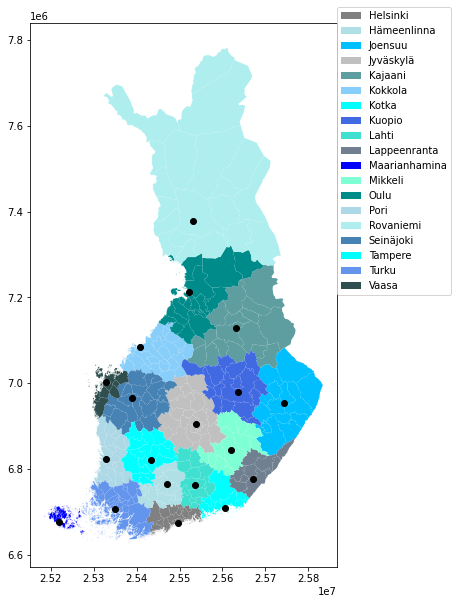

In [109]:
figure, axs = plt.subplots(nrows=1, ncols=1, figsize=(25,10), squeeze=False)

for group, key, color in zip(grouped, keys, colors):
    grouped.get_group(key).plot(ax=axs[0,0], 
                                color=color);
    
geokeskus.plot(ax=axs[0,0], 
               color="black",
               );    

# Set the legend

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Below some failed attempts at creating a legend with a for loop.
# Last one (creating a legend through an empty plot) actually worked, but it looked a bit stupid as the colors were lines in it. 
# Additionally, I couldn't figure out how to add the names of the cities into it since it didn't accept a list of the names as a parameter in "label=".

# Create a legend using for loop

# for clr, lbl in zip(colors, labels):
#    Hel_patch, Ham_patch,Joe_patch,Jyv_patch,Kaj_patch,Kok_patch,Kot_patch,Kuo_patch,Lah_patch,Lap_patch,Mar_patch,Mik_patch,Oul_patch,Por_patch,Rov_patch,Sei_patch,Tam_patch,Tur_patch,Vaa_patch = mpatches.Patch(color=clr, label=lbl)
#    axs[0,0].legend(handles=[Hel_patch, Ham_patch,Joe_patch,Jyv_patch,Kaj_patch,Kok_patch,Kot_patch,Kuo_patch,Lah_patch,Lap_patch,Mar_patch,Mik_patch,Oul_patch,Por_patch,Rov_patch,Sei_patch,Tam_patch,Tur_patch,Vaa_patch]);

# This one doesn't work at all, results in 'TypeError: cannot unpack non-iterable int object' 

# Second try:

# for clr, lbl in zip(colors, labels):
#    patch = mpatches.Patch(color=clr, label=lbl)
#    axs[0,0].legend(handles=[patch]);

# This one creates a legend, but it only has one item: last one, Vaasa
    
# Third try: Create a legend using a for loop and an iterator

# patchlist = []

# for clr, lbl in zip(colors, labels):
#    ptch = mpatches.Patch(color=clr, label=lbl)
#    patchlist.append(ptch));
    
# class iterator(object):
#    def __init__(self):
#        self.list = patchlist
#    def __iter__(self):
#        return iter(self.list)    

# iterlist = iterator()    
# for ptch in iterator:
#    axs[0,0].legend(handles=[ptch])

# Nope, doesn't work.

# Last try: Create a legend through an empty plot

# colmap = ListedColormap(colors)    

# [axs[0,0].plot([], [], color=colmap(i), label=labels[a]) for i,a in range(len(grouped))]
# axs[0,0].legend()

# classes = ['A','B','C']
# class_colours = ['r','b','g']
recs = []
for i in range(0,len(colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i]))
axs[0,0].legend(recs,labels,loc=(1.05,0.))

# This one works in a way, but not as I would want it to work. 


In [ ]:
# So, I ended up adding the legend manually.

Hel_patch = mpatches.Patch(color="grey", label="Helsinki")
Ham_patch = mpatches.Patch(color="powderblue", label="Hämeenlinna")
Joe_patch = mpatches.Patch(color="deepskyblue", label="Joensuu")
Jyv_patch = mpatches.Patch(color="silver", label="Jyväskylä")
Kaj_patch = mpatches.Patch(color="cadetblue", label="Kajaani")
Kok_patch = mpatches.Patch(color="lightskyblue", label="Kokkola")
Kot_patch = mpatches.Patch(color="aqua", label="Kotka")
Kuo_patch = mpatches.Patch(color="royalblue", label="Kuopio")
Lah_patch = mpatches.Patch(color="turquoise", label="Lahti")
Lap_patch = mpatches.Patch(color="slategrey", label="Lappeenranta")
Mar_patch = mpatches.Patch(color="blue", label="Maarianhamina")
Mik_patch = mpatches.Patch(color="aquamarine", label="Mikkeli")
Oul_patch = mpatches.Patch(color="darkcyan", label="Oulu")
Por_patch = mpatches.Patch(color="lightblue", label="Pori")
Rov_patch = mpatches.Patch(color="paleturquoise", label="Rovaniemi")
Sei_patch = mpatches.Patch(color="steelblue", label="Seinäjoki")
Tam_patch = mpatches.Patch(color="cyan", label="Tampere")
Tur_patch = mpatches.Patch(color="cornflowerblue", label="Turku")
Vaa_patch = mpatches.Patch(color="darkslategrey", label="Vaasa")

axes[0,0].legend(handles=[Hel_patch, Ham_patch, Joe_patch, Jyv_patch, Kaj_patch, Kok_patch, Kot_patch, Kuo_patch, Lah_patch, Lap_patch, Mar_patch, Mik_patch, Oul_patch, Por_patch, Rov_patch, Sei_patch, Tam_patch, Tur_patch, Vaa_patch])

axs[0,0].get_legend().set_bbox_to_anchor((1.4, 1.01))
# axs[0,0].get_legend().set_title("Dominant city")

#plt.tight_layout()

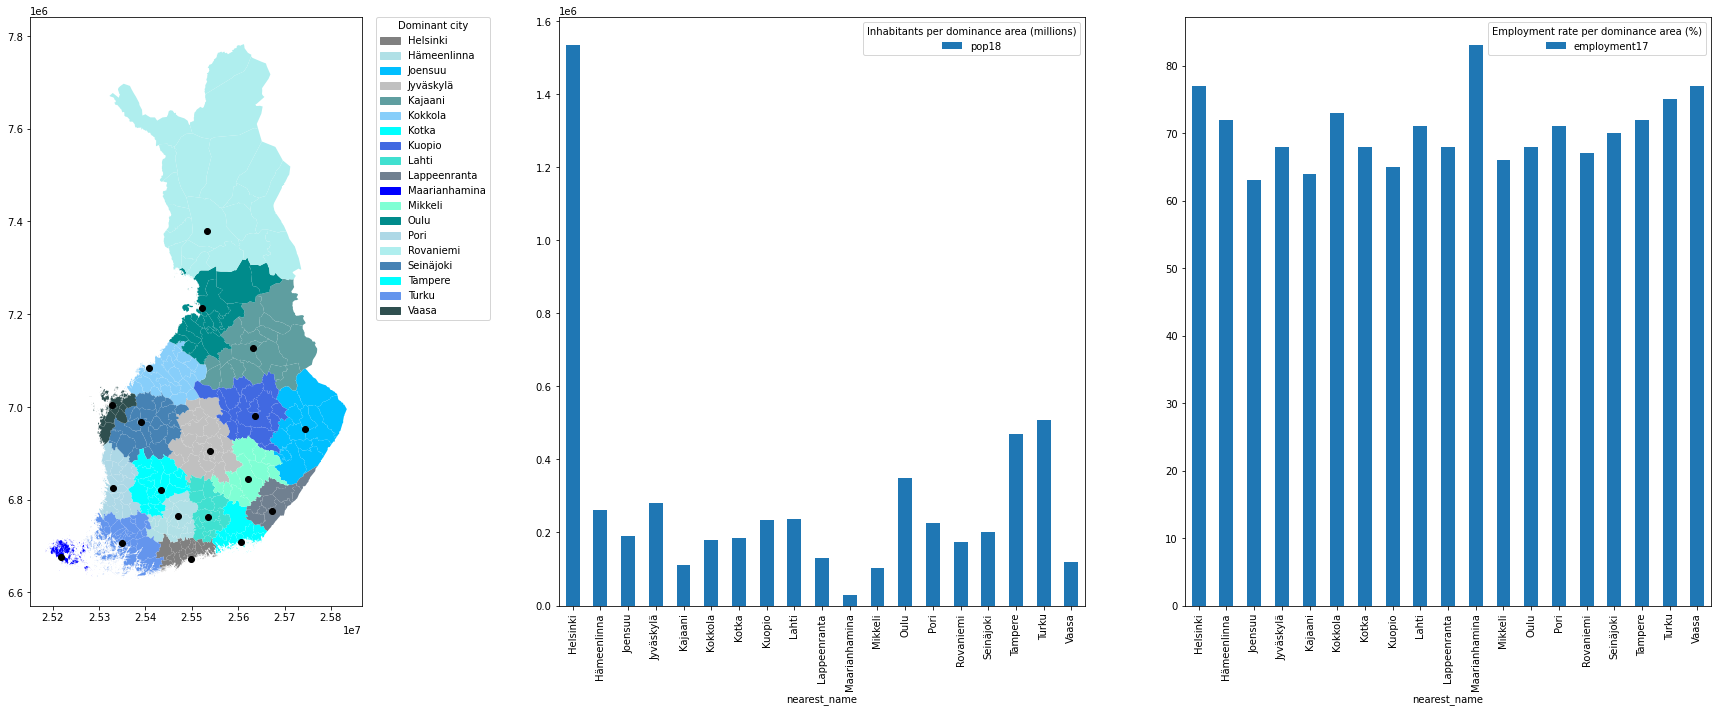

In [35]:
# Define output filename for the figure in here and use it when saving the file
# output_fig2 = "static_map_final.png"

# I couldn't figure out how to plot the dominance areas of region center cities inside a loop (mainly the color would've been a problem), so here's my extremely inefficient approach:

figure, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,10))

grouped.get_group("Helsinki").plot(ax=axs[0],
                                   color="grey"
                                  );

grouped.get_group("Hämeenlinna").plot(ax=axs[0],
                                      color="powderblue"
                                     );

grouped.get_group("Joensuu").plot(ax=axs[0],
                                  color="deepskyblue"
                                 );

grouped.get_group("Jyväskylä").plot(ax=axs[0],
                                    color="silver"
                                   );

grouped.get_group("Kajaani").plot(ax=axs[0],
                                    color="cadetblue"
                                   );

grouped.get_group("Kokkola").plot(ax=axs[0],
                                    color="lightskyblue"
                                   );

grouped.get_group("Kotka").plot(ax=axs[0],
                                    color="aqua"
                                   );

grouped.get_group("Kuopio").plot(ax=axs[0],
                                    color="royalblue"
                                   );

grouped.get_group("Lahti").plot(ax=axs[0],
                                    color="turquoise"
                                   );

grouped.get_group("Lappeenranta").plot(ax=axs[0],
                                    color="slategray"
                                   );

grouped.get_group("Maarianhamina").plot(ax=axs[0],
                                    color="blue"
                                   );

grouped.get_group("Mikkeli").plot(ax=axs[0],
                                    color="aquamarine"
                                   );

grouped.get_group("Oulu").plot(ax=axs[0],
                                    color="darkcyan"
                                   );

grouped.get_group("Pori").plot(ax=axs[0],
                                    color="lightblue"
                                   );

grouped.get_group("Rovaniemi").plot(ax=axs[0],
                                    color="paleturquoise"
                                   );

grouped.get_group("Seinäjoki").plot(ax=axs[0],
                                    color="steelblue"
                                   );

grouped.get_group("Tampere").plot(ax=axs[0],
                                    color="cyan"
                                   );

grouped.get_group("Turku").plot(ax=axs[0],
                                    color="cornflowerblue"
                                   );

grouped.get_group("Vaasa").plot(ax=axs[0],
                                    color="darkslategrey"
                                   );

geokeskus.plot(ax=axs[0], 
               color="black",
               );

groupeddata.plot.bar(ax=axs[1],
                     x="nearest_name", 
                     y="pop18",
                     legend=True
                    );

groupeddata.plot.bar(ax=axs[2],
                     x="nearest_name", 
                     y="employment17",
                     legend=True
                    );

# Reposition the legend for population and employment data

axs[1].get_legend().set_title("Inhabitants per dominance area (millions)")
axs[2].get_legend().set_title("Employment rate per dominance area (%)")

# Create the legend for region center's dominance areas by hand, reposition the legend, and set a title
# Not much automation here unfortunately :DDD

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

Hel_patch = mpatches.Patch(color="grey", label="Helsinki")
Ham_patch = mpatches.Patch(color="powderblue", label="Hämeenlinna")
Joe_patch = mpatches.Patch(color="deepskyblue", label="Joensuu")
Jyv_patch = mpatches.Patch(color="silver", label="Jyväskylä")
Kaj_patch = mpatches.Patch(color="cadetblue", label="Kajaani")
Kok_patch = mpatches.Patch(color="lightskyblue", label="Kokkola")
Kot_patch = mpatches.Patch(color="aqua", label="Kotka")
Kuo_patch = mpatches.Patch(color="royalblue", label="Kuopio")
Lah_patch = mpatches.Patch(color="turquoise", label="Lahti")
Lap_patch = mpatches.Patch(color="slategrey", label="Lappeenranta")
Mar_patch = mpatches.Patch(color="blue", label="Maarianhamina")
Mik_patch = mpatches.Patch(color="aquamarine", label="Mikkeli")
Oul_patch = mpatches.Patch(color="darkcyan", label="Oulu")
Por_patch = mpatches.Patch(color="lightblue", label="Pori")
Rov_patch = mpatches.Patch(color="paleturquoise", label="Rovaniemi")
Sei_patch = mpatches.Patch(color="steelblue", label="Seinäjoki")
Tam_patch = mpatches.Patch(color="cyan", label="Tampere")
Tur_patch = mpatches.Patch(color="cornflowerblue", label="Turku")
Vaa_patch = mpatches.Patch(color="darkslategrey", label="Vaasa")

axs[0].legend(handles=[Hel_patch, Ham_patch, Joe_patch, Jyv_patch, Kaj_patch, Kok_patch, Kot_patch, Kuo_patch, Lah_patch, Lap_patch, Mar_patch, Mik_patch, Oul_patch, Por_patch, Rov_patch, Sei_patch, Tam_patch, Tur_patch, Vaa_patch])

axs[0].get_legend().set_bbox_to_anchor((1.4, 1.01))
axs[0].get_legend().set_title("Dominant city")

plt.tight_layout()

# Save the image to file

# plt.savefig(output_fig2)

So, above are three figures:

1. The dominance areas of region center cities (maakuntakeskukset). As I expected, they look quite a lot like current regions (maakunnat), but there are differences, too. The information could be combined with other data sets and be used to for example study, where do people travel to work from municipalities: do they cross current regions borders or not etc.

2. Population (million inhabitants) per dominance area.

3. Average employment rate per dominance area (calculated by taking a mean from the municipalities' employment rates in a certain dominance area).

All data is originally from Statistics Finland.